In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.impute import KNNImputer

# Načítanie údajov z datasetu

In [2]:
first_dataset="data/product.csv"
products = pd.read_csv(first_dataset, sep='\t')
second_dataset="data/session.csv"
sessions = pd.read_csv(second_dataset, sep='\t')
third_dataset="data/user.csv"
users = pd.read_csv(third_dataset, sep='\t')
merged_data = sessions.merge(users, on="user_id", how="inner")

# Transformácia dát 

Atribút browser transformujeme na číselnú reprezentáciu : 
'1' <- 'chrome'
'2' <- 'edge'
'3' <- 'firefox'
'4' <- 'mobile'
'5' <- 'safari'
'6' <- 'opera'
'7' <- 'other'

In [3]:
merged_data['browser_name'] = merged_data['browser_name'].str.replace('chrome',"1")
merged_data['browser_name'] = merged_data['browser_name'].str.replace('edge',"2")
merged_data['browser_name'] = merged_data['browser_name'].str.replace('firefox',"3")
merged_data['browser_name'] = merged_data['browser_name'].str.replace('mobile',"4")
merged_data['browser_name'] = merged_data['browser_name'].str.replace('safari',"5")
merged_data['browser_name'] = merged_data['browser_name'].str.replace('opera',"6")
merged_data['browser_name'] = merged_data['browser_name'].str.replace('other',"7")

In [4]:
merged_data.head()

,session_duration,wild_mouse_duration,pct_scroll_move,screen_width,product_ean,pct_doubleclick,browser_name,user_id,pct_mouse_click,pct_mouse_move,...,residence,registration,mail,sex,username,birthdate,name,job,race,address
0,236.88961,10.28554,36.92911,800,2193503010008,10.53409,1,599,9.97809,12.85887,...,NaN,21 Jun 2014,akemi53@hotmail.com,M,yukikimura,NaN,佐藤 裕樹,アートディレクター,NaN,NaN
1,236.88961,10.28554,36.92911,800,2193503010008,10.53409,1,599,9.97809,12.85887,...,NaN,2022/09/30,marinasilveira@yahoo.com.br,F,fariaslucca,1980-02-06,Natália Souza,Engenheiro florestal,NaN,Vale de Sales\r\nDelta\r\n59441702 Ribeiro de ...
2,236.88961,10.28554,36.92911,800,2193503010008,10.53409,1,599,9.97809,12.85887,...,NaN,2021-11-07,luiz-gustavo93@uol.com.br,M,camposvicente,NaN,João Lucas Martins,Harpista,white,"Vereda de Cardoso, 329\r\nVila Da Paz\r\n57742..."
3,236.88961,10.28554,36.92911,800,2193503010008,10.53409,1,599,9.97809,12.85887,...,NaN,2015/09/18,ricciardigreca@tiscali.it,M,chindamorolando,NaN,Alfio Mazzanti,Maintenance engineer,asian,"Contrada Ajello, 62\r\n50126, Badia A Ripoli (FI)"
4,170.81241,8.79009,56.08060,lower,8370023837863,11.00398,4,599,9.79988,11.85339,...,NaN,21 Jun 2014,akemi53@hotmail.com,M,yukikimura,NaN,佐藤 裕樹,アートディレクター,NaN,NaN


# Nahradzovanie chýbajúcich hodnôt

V tabuľke nižšie je možné vidieť, že máme veľa chýbajúcich hodnôt, tieto hodnoty musíme nahradiť

In [5]:
merged_data.isnull().sum()

session_duration                     0
wild_mouse_duration                 11
pct_scroll_move                     17
screen_width                         0
product_ean                          0
pct_doubleclick                     10
browser_name                         0
user_id                              0
pct_mouse_click                     16
pct_mouse_move                       7
pct_wild_mouse                      16
pct_click_product_info               7
mouse_move_total_rel_distance        9
scroll_move_total_rel_distance      10
page_activity_duration              14
session_start                        0
session_id                           0
screen_height                        0
pct_input                           13
pct_scrandom                         9
pct_rage_click                       8
ack                                  0
pct_scroll_move_duration            15
pct_click                           10
total_load_time                      0
residence                

Niektoré atribúty majú veľmi nízku koreláciu s ostatnými, alebo pre nás majú nulový výzanm, preto môžeme buď ostrániť nulové hodnoty týchto atribútov, alebo odstránime atribút celkovo. 

In [6]:
merged_data=merged_data.dropna(subset=['pct_scrandom','pct_mouse_click','pct_rage_click','pct_click_product_info','pct_scroll_move','pct_wild_mouse'])

In [7]:
merged_data.drop(['address','job','residence'], axis = 1, errors = 'ignore', inplace = True)

Atribúty, ako napr. sex, birthdate a race majú obrovské množstvo chýbajúcich hodnôt a tieto hodnoty sa nedajú nijak rozumne nahradiť, tak tieto atribúty tiež odstránime(tu si nie som istý či sa to má riešiť takto ale nič iné ma nenapadá)

In [8]:
merged_data.drop(['sex','birthdate','race'], axis = 1, errors = 'ignore', inplace = True)

Chýbajúce hodnoty v stĺpcoch "wld_mouse_duration", "page_activity_duration", "pct_input", "pct_mouse_move" sme nahradili priemernými hodnotami daných atribútov

In [9]:
def nan_to_mean(data):
    wild_duration_mean = data['wild_mouse_duration'].mean()
    page_activity_duration_mean = data['page_activity_duration'].mean()
    pct_input_mean = data['pct_input'].mean()
    pct_mouse_move_mean = data['pct_mouse_move'].mean()
    data['wild_mouse_duration'] = data['wild_mouse_duration'].fillna(wild_duration_mean)
    data['pct_input'] = data['pct_input'].fillna(pct_input_mean)
    data['page_activity_duration'] = data['page_activity_duration'].fillna(page_activity_duration_mean)
    data['pct_mouse_move'] = data['pct_mouse_move'].fillna(pct_mouse_move_mean)

nan_to_mean(merged_data)

Chýbajúce hodnoty v stĺpcoch "pct_doubleclick", "mouse_move_total_rel_distance" a "pct_scroll_move_duration" sme nahradili ich mediánom, vzhľadom na ich korelácie zistené v predchádzajúcej fáze

In [10]:
def nan_to_median(data):
    pct_doubleclick_median = data['pct_doubleclick'].median()
    mouse_move_total_dist_median = data['mouse_move_total_rel_distance'].median()
    pct_scroll_move_duration_median = data['pct_scroll_move_duration'].median()
    data['pct_scroll_move_duration'] = data['pct_scroll_move_duration'].fillna(pct_scroll_move_duration_median)
    data['pct_doubleclick'] = data['pct_doubleclick'].fillna(pct_doubleclick_median)
    data['mouse_move_total_rel_distance'] = data['mouse_move_total_rel_distance'].fillna(mouse_move_total_dist_median)

nan_to_median(merged_data)

V stĺpcoch "scroll_move_total_rel_distance" a "pct_click" sme ich chýbajúce hodnoty nahradili pomocou KNN algoritmu

In [11]:
def nan_to_knn(data):
    imputer = KNNImputer()
    imputed_data = pd.DataFrame(imputer.fit_transform(data[['scroll_move_total_rel_distance','pct_click']]))
    data['scroll_move_total_rel_distance'] = imputed_data[0].values
    data['pct_click'] = imputed_data[1].values

nan_to_knn(merged_data)

In [12]:
merged_data.isnull().sum()

session_duration                  0
wild_mouse_duration               0
pct_scroll_move                   0
screen_width                      0
product_ean                       0
pct_doubleclick                   0
browser_name                      0
user_id                           0
pct_mouse_click                   0
pct_mouse_move                    0
pct_wild_mouse                    0
pct_click_product_info            0
mouse_move_total_rel_distance     0
scroll_move_total_rel_distance    0
page_activity_duration            0
session_start                     0
session_id                        0
screen_height                     0
pct_input                         0
pct_scrandom                      0
pct_rage_click                    0
ack                               0
pct_scroll_move_duration          0
pct_click                         0
total_load_time                   0
registration                      0
mail                              0
username                    

# Odstráňovanie vychýlených hodnôt

In [13]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10983 entries, 0 to 11055
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   session_duration                10983 non-null  float64
 1   wild_mouse_duration             10983 non-null  float64
 2   pct_scroll_move                 10983 non-null  float64
 3   screen_width                    10983 non-null  object 
 4   product_ean                     10983 non-null  int64  
 5   pct_doubleclick                 10983 non-null  float64
 6   browser_name                    10983 non-null  object 
 7   user_id                         10983 non-null  int64  
 8   pct_mouse_click                 10983 non-null  float64
 9   pct_mouse_move                  10983 non-null  float64
 10  pct_wild_mouse                  10983 non-null  float64
 11  pct_click_product_info          10983 non-null  float64
 12  mouse_move_total_rel_distance   10983

C:\Users\Patrik\AppData\Local\Temp\ipykernel_20852\346937668.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  merged_data.hist(ax = ax, color="red")


array([[<Axes: title={'center': 'session_duration'}>,
        <Axes: title={'center': 'wild_mouse_duration'}>,
        <Axes: title={'center': 'pct_scroll_move'}>,
        <Axes: title={'center': 'product_ean'}>,
        <Axes: title={'center': 'pct_doubleclick'}>],
       [<Axes: title={'center': 'user_id'}>,
        <Axes: title={'center': 'pct_mouse_click'}>,
        <Axes: title={'center': 'pct_mouse_move'}>,
        <Axes: title={'center': 'pct_wild_mouse'}>,
        <Axes: title={'center': 'pct_click_product_info'}>],
       [<Axes: title={'center': 'mouse_move_total_rel_distance'}>,
        <Axes: title={'center': 'scroll_move_total_rel_distance'}>,
        <Axes: title={'center': 'page_activity_duration'}>,
        <Axes: title={'center': 'session_id'}>,
        <Axes: title={'center': 'pct_input'}>],
       [<Axes: title={'center': 'pct_scrandom'}>,
        <Axes: title={'center': 'pct_rage_click'}>,
        <Axes: title={'center': 'ack'}>,
        <Axes: title={'center': 'pct

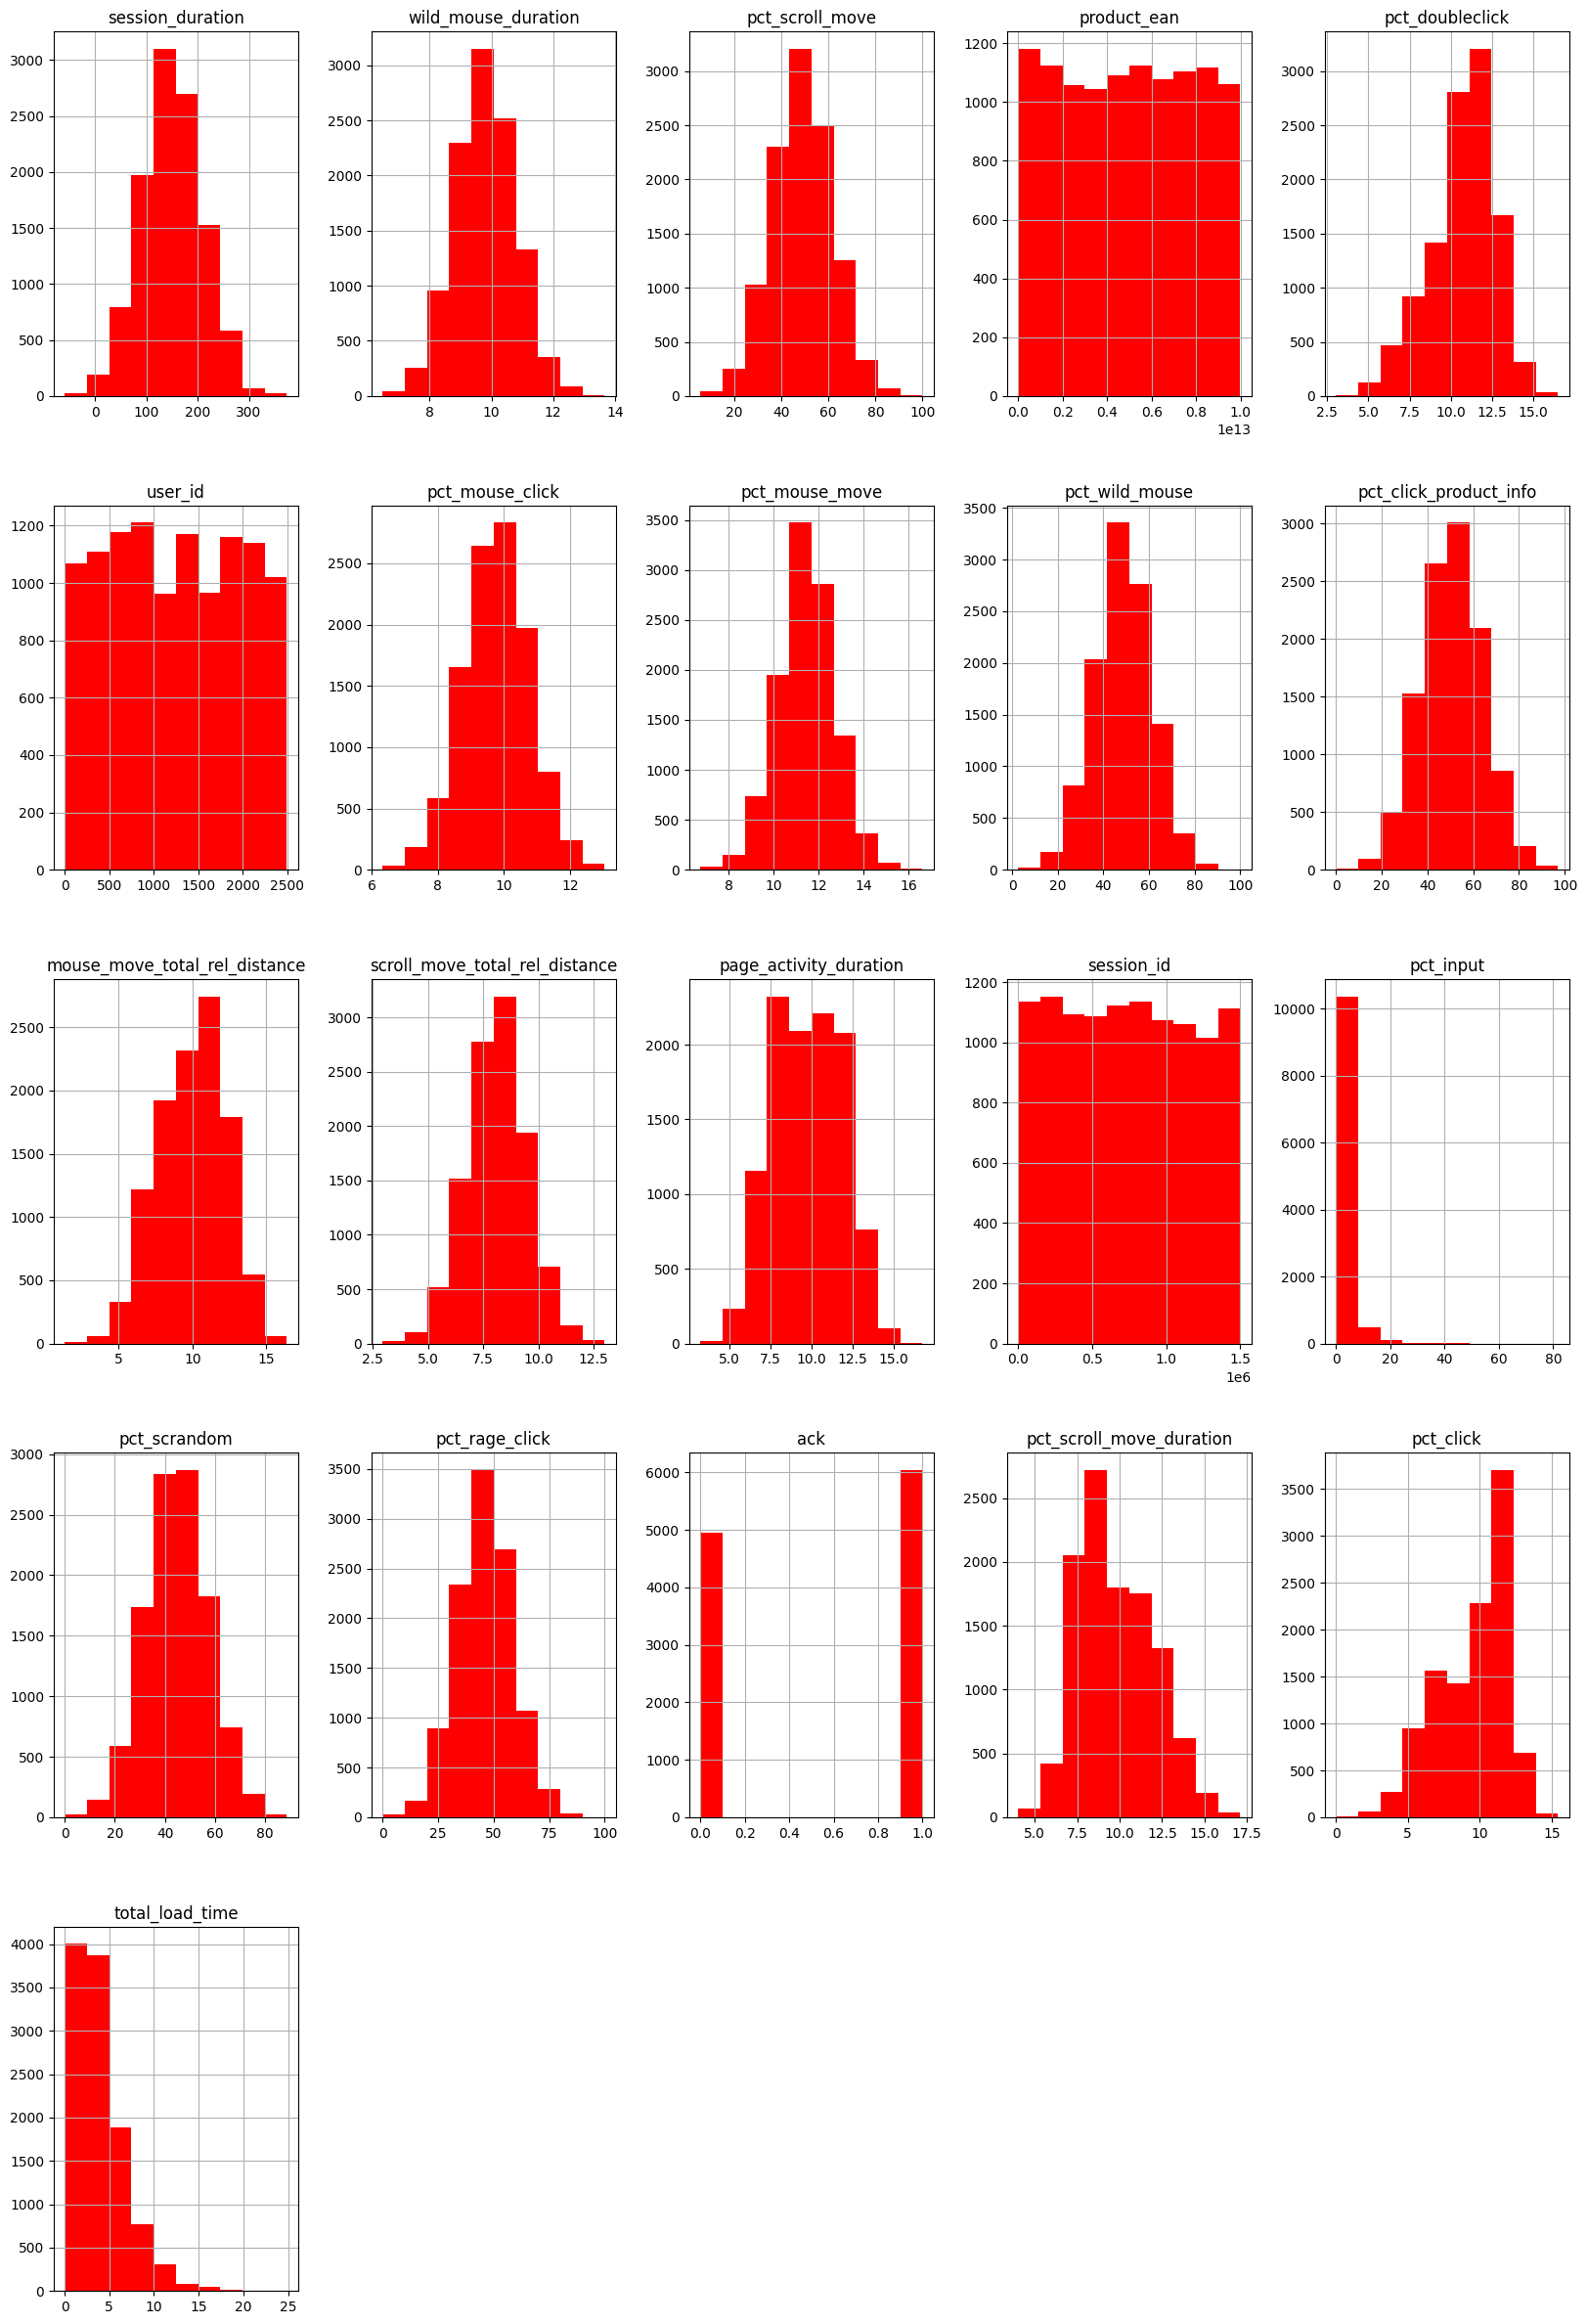

In [14]:
fig = plt.figure(figsize = (20,30))
ax = fig.gca()
merged_data.hist(ax = ax, color="red")

Vidíme, že máme vel'a vychýlených hodnôt, preto tento problém vyriešime spôsobom odstránenia vychýlených (odľahlých) pozorovaní (prvý spôsob) a nahradenia vychýlenej hodnoty hraničnými hodnotami rozdelenia (5% a 95%)

In [15]:
columns= ['session_duration','wild_mouse_duration','pct_scroll_move', 'product_ean', 'user_id','pct_mouse_click','pct_mouse_move','pct_wild_mouse', 'pct_click_product_info' ,'mouse_move_total_rel_distance', 'scroll_move_total_rel_distance','page_activity_duration','session_id','pct_input','pct_scrandom','pct_rage_click','ack','pct_scroll_move_duration','pct_click','total_load_time']
for column_name in columns:
    lower_limit = merged_data[column_name].quantile(0.05)
    upper_limit = merged_data[column_name].quantile(0.95)

    filtered_data_first = merged_data[(merged_data[column_name] >= lower_limit) & (merged_data[column_name] <= upper_limit)]

C:\Users\Patrik\AppData\Local\Temp\ipykernel_20852\491447311.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  filtered_data_first.hist(ax = ax, color="red")


array([[<Axes: title={'center': 'session_duration'}>,
        <Axes: title={'center': 'wild_mouse_duration'}>,
        <Axes: title={'center': 'pct_scroll_move'}>,
        <Axes: title={'center': 'product_ean'}>,
        <Axes: title={'center': 'pct_doubleclick'}>],
       [<Axes: title={'center': 'user_id'}>,
        <Axes: title={'center': 'pct_mouse_click'}>,
        <Axes: title={'center': 'pct_mouse_move'}>,
        <Axes: title={'center': 'pct_wild_mouse'}>,
        <Axes: title={'center': 'pct_click_product_info'}>],
       [<Axes: title={'center': 'mouse_move_total_rel_distance'}>,
        <Axes: title={'center': 'scroll_move_total_rel_distance'}>,
        <Axes: title={'center': 'page_activity_duration'}>,
        <Axes: title={'center': 'session_id'}>,
        <Axes: title={'center': 'pct_input'}>],
       [<Axes: title={'center': 'pct_scrandom'}>,
        <Axes: title={'center': 'pct_rage_click'}>,
        <Axes: title={'center': 'ack'}>,
        <Axes: title={'center': 'pct

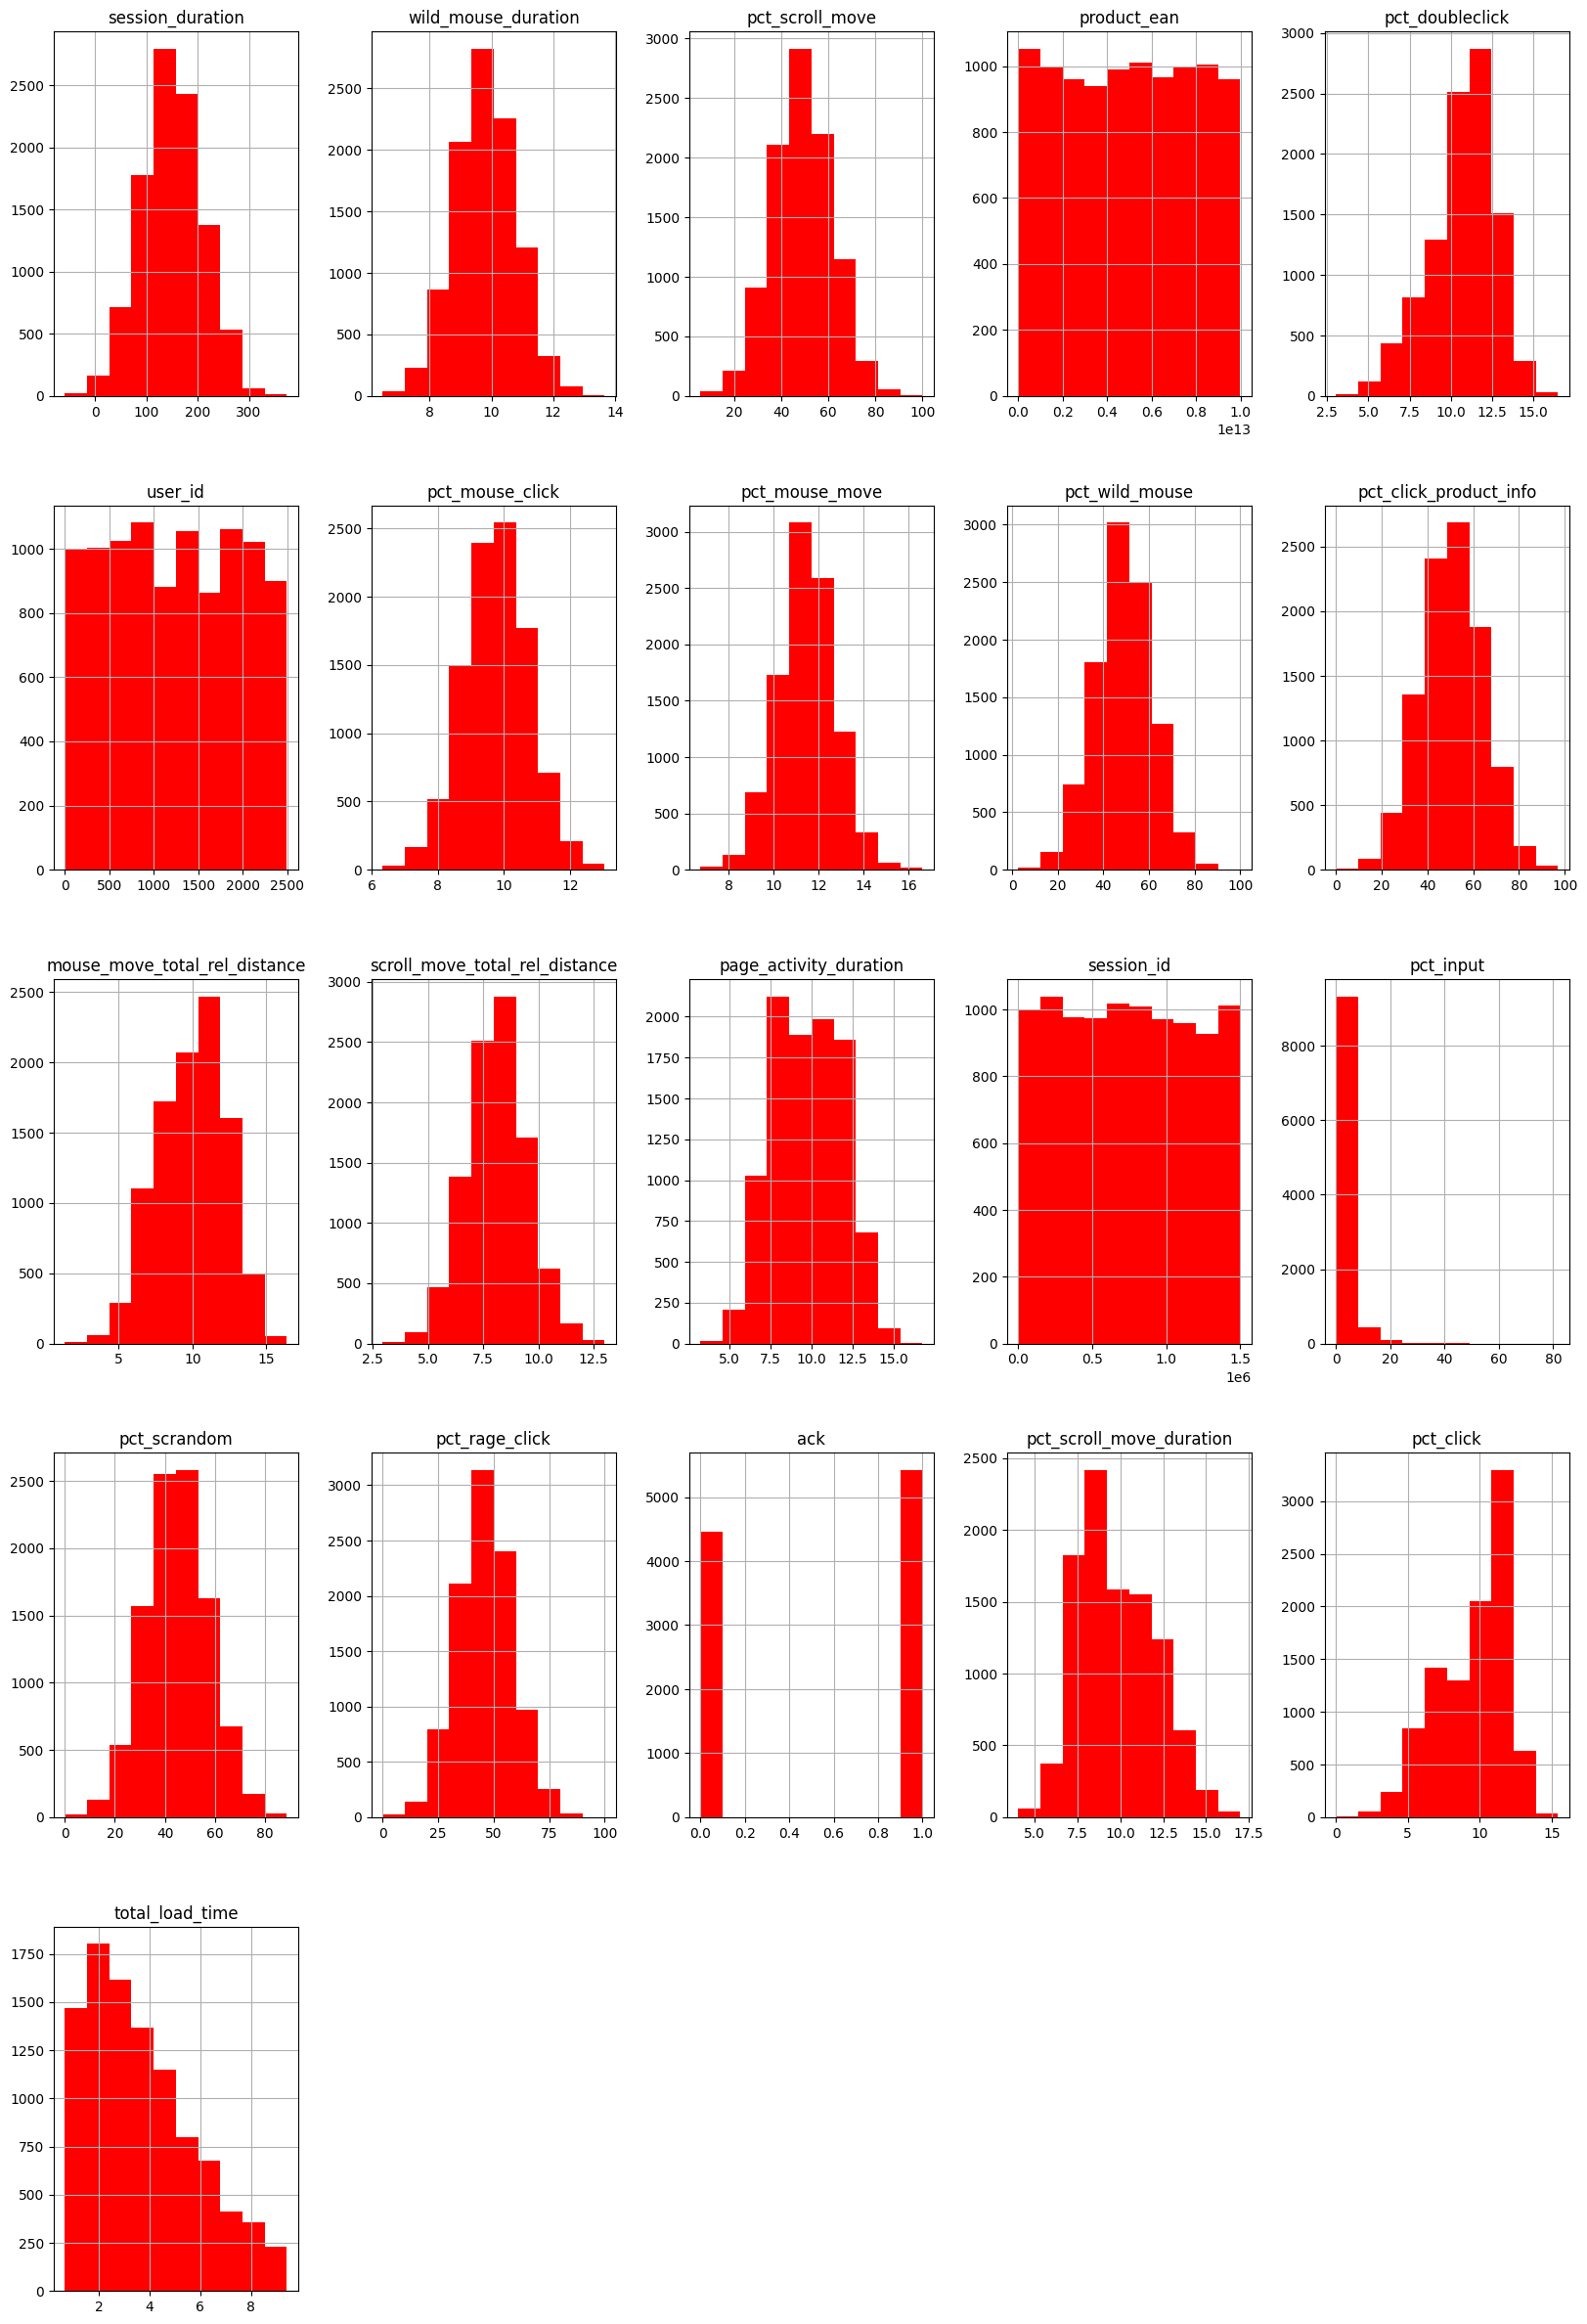

In [16]:
fig = plt.figure(figsize = (20,30))
ax = fig.gca()
filtered_data_first.hist(ax = ax, color="red")

In [17]:
columns= ['session_duration','wild_mouse_duration','pct_scroll_move', 'product_ean', 'user_id','pct_mouse_click','pct_mouse_move','pct_wild_mouse', 'pct_click_product_info' ,'mouse_move_total_rel_distance', 'scroll_move_total_rel_distance','page_activity_duration','session_id','pct_input','pct_scrandom','pct_rage_click','ack','pct_scroll_move_duration','pct_click','total_load_time']
for column_name in columns:
    lower_limit = merged_data[column_name].quantile(0.05)
    upper_limit = merged_data[column_name].quantile(0.95)
    
    merged_data[column_name] = np.where(merged_data[column_name] < lower_limit, lower_limit, merged_data[column_name])
    merged_data[column_name] = np.where(merged_data[column_name] > upper_limit, upper_limit, merged_data[column_name])

C:\Users\Patrik\AppData\Local\Temp\ipykernel_20852\346937668.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  merged_data.hist(ax = ax, color="red")


array([[<Axes: title={'center': 'session_duration'}>,
        <Axes: title={'center': 'wild_mouse_duration'}>,
        <Axes: title={'center': 'pct_scroll_move'}>,
        <Axes: title={'center': 'product_ean'}>,
        <Axes: title={'center': 'pct_doubleclick'}>],
       [<Axes: title={'center': 'user_id'}>,
        <Axes: title={'center': 'pct_mouse_click'}>,
        <Axes: title={'center': 'pct_mouse_move'}>,
        <Axes: title={'center': 'pct_wild_mouse'}>,
        <Axes: title={'center': 'pct_click_product_info'}>],
       [<Axes: title={'center': 'mouse_move_total_rel_distance'}>,
        <Axes: title={'center': 'scroll_move_total_rel_distance'}>,
        <Axes: title={'center': 'page_activity_duration'}>,
        <Axes: title={'center': 'session_id'}>,
        <Axes: title={'center': 'pct_input'}>],
       [<Axes: title={'center': 'pct_scrandom'}>,
        <Axes: title={'center': 'pct_rage_click'}>,
        <Axes: title={'center': 'ack'}>,
        <Axes: title={'center': 'pct

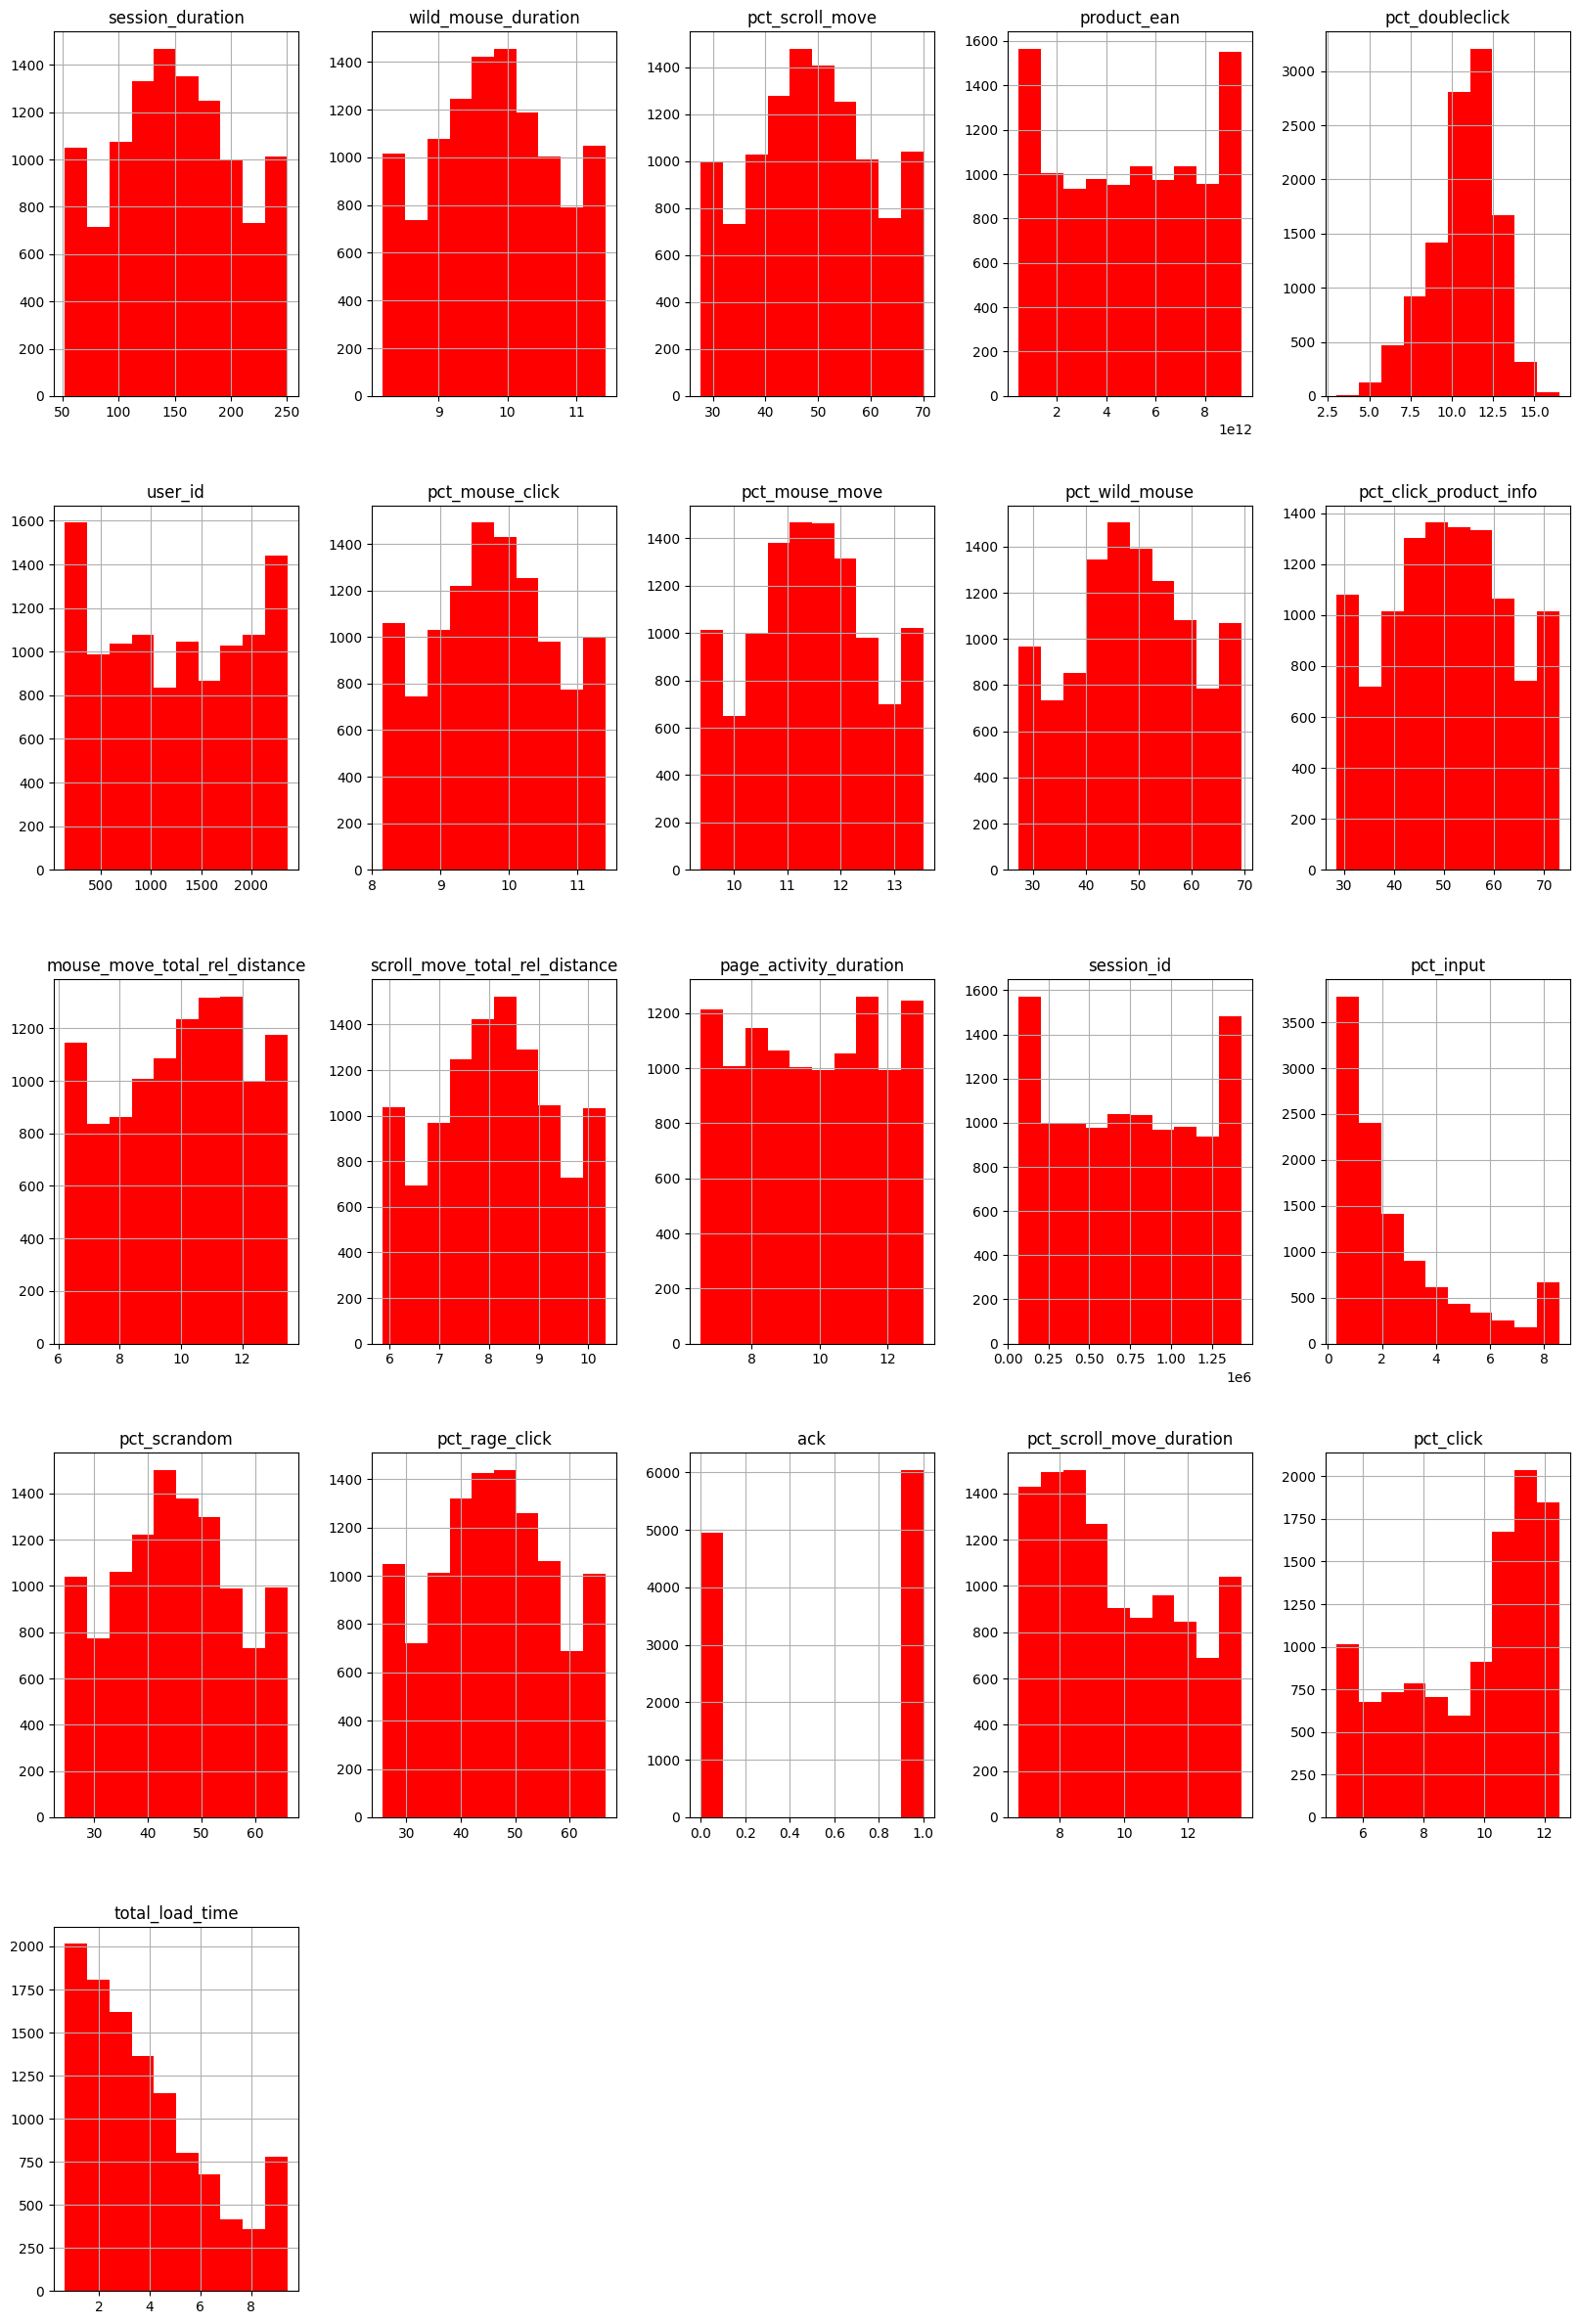

In [18]:
fig = plt.figure(figsize = (20,30))
ax = fig.gca()
merged_data.hist(ax = ax, color="red")